In [1]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Linear least-squares problem

In [2]:
X = np.array([[1, 274, 2450],
             [1, 180, 3254],
             [1, 375, 3802],
             [1, 205, 2838],
             [1, 86, 2347]])
Y = np.array([[162],
             [120],
             [223],
             [131],
             [67]])
print("X = ")
print()
print(X)
print()
print("Y = ")
print()
print(Y)

X = 

[[   1  274 2450]
 [   1  180 3254]
 [   1  375 3802]
 [   1  205 2838]
 [   1   86 2347]]

Y = 

[[162]
 [120]
 [223]
 [131]
 [ 67]]


### Solution using Cholesky algorithm

In [3]:
L = npl.cholesky(np.dot(X.T,X)) # Result is a lower triangular matrix
z = np.dot(X.T,Y)
p = npl.solve(L,z)
beta_hat_chol = npl.solve(L.T,p)
print("beta_hat_chol = ")
print()
print(beta_hat_chol)

beta_hat_chol = 

[[7.03250343e+00]
 [5.04447596e-01]
 [7.00130524e-03]]


### Solution using QR factorization

In [4]:
Q, R = npl.qr(X)
Z = np.dot(Q.T, Y)
beta_hat_qr = npl.solve(R,Z)
print("beta_hat_qr = ")
print()
print(beta_hat_qr)

beta_hat_qr = 

[[7.03250343e+00]
 [5.04447596e-01]
 [7.00130524e-03]]


### Solution using SVD approach

In [5]:
U, S, V_transpose = npl.svd(X)
b = np.dot(U.T,Y)
z = npl.solve(np.diag(S),b[:3])
beta_hat_svd = np.dot(V_transpose.T, z)
print("beta_hat_svd = ")
print()
print(beta_hat_svd)

beta_hat_svd = 

[[7.03250343e+00]
 [5.04447596e-01]
 [7.00130524e-03]]


## Nonlinear least-sqaures problem
$$y = \theta_1e^{\theta_2x}$$

### Oginal data

In [6]:
x_data = np.array([0, 1, 2, 3])
y = np.array([2, 0.7, 0.3, 0.1])

We convert the data into column vectors so that we can vectorize later operations.

In [7]:
x_data = np.vstack(x_data)
y = np.vstack(y)

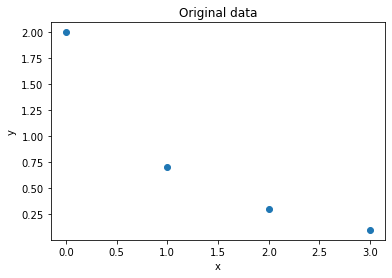

In [8]:
plt.figure()
plt.plot(x_data,y, 'o')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Original data")
plt.show()

## Newton's method

Define residual function

In [9]:
def residual_function(theta):
    return(y - theta[0]*np.exp(theta[1]*x_data))

Define Jacobian

In [10]:
def Jacobian(theta):
    return(np.hstack([-np.exp(theta[1]*x_data), -theta[0]*x_data*np.exp(theta[1]*x_data)]))

Gradient function

In [11]:
def gradient(theta):
    return(np.dot(Jacobian(theta).T, residual_function(theta)))

In [12]:
def Hessian_second_term(theta):
    result = 0
    for i in range(len(x_data)):
        hessian_of_residual = np.asarray([[0, -(x_data[i]*np.exp(theta[1]*x_data[i])).item()],
                                          [-(x_data[i]*np.exp(theta[1]*x_data[i])).item(), -(theta[0]*np.square(x_data[i])*np.exp(theta[1]*x_data[i])).item()]])
        residual = y[i]- theta[0]*np.exp(theta[1]*x_data[i])
        result = result + residual*hessian_of_residual
    return result

In [13]:
def Hessian(theta):
    jacobian = Jacobian(theta)
    second_term = Hessian_second_term(theta)
    result = np.dot(jacobian.T, jacobian) + second_term
    return result

Initial guess of parametes.

In [14]:
theta_initial = np.vstack([1,0])
theta_initial

array([[1],
       [0]])

In [15]:
def Newton(f,grad,hess, theta,alpha, kmax = 20, tol = 1e-6):
    x = theta
    fnorms = []
    succ_approx_newton = [np.hstack(x)]
    for k in range(kmax):
        fk = f(x)
        fnorms.append(npl.norm(fk))
        if npl.norm(fk) < tol:
            break
        x = x - alpha*npl.solve(hess(x), grad(x))
        succ_approx_newton.append(np.hstack(x))
    return x, np.vstack(fnorms), np.vstack(succ_approx_newton)

In [16]:
new_theta_newton, residual_norms, succ_approx_newton = Newton(residual_function, gradient, Hessian, 
                                                              theta_initial, alpha = 0.05, kmax = 500)

In [17]:
new_theta_newton

array([[ 1.99500328],
       [-1.00952447]])

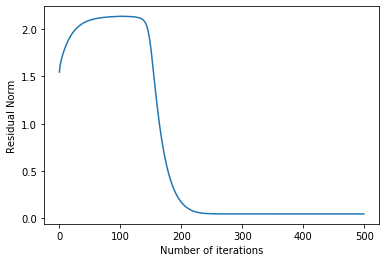

In [18]:
plt.figure()
plt.plot(residual_norms)
plt.xlabel("Number of iterations")
plt.ylabel("Residual Norm")
plt.show()

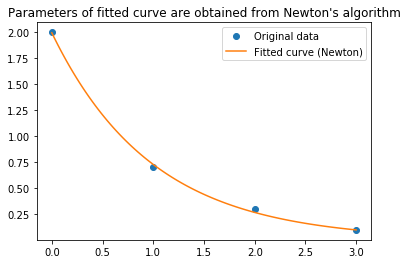

In [19]:
plt.figure()
x = np.linspace(0, 3, 100)
y_newton = new_theta_newton[0]*np.exp(new_theta_newton[1]*x)
plt.plot(x_data, y, 'o', label = "Original data")
plt.plot(x, y_newton, label = "Fitted curve (Newton)")
plt.legend()
plt.title("Parameters of fitted curve are obtained from Newton's algorithm")
plt.show()

## Gauss-Newton's method
We will use codes for Gauss-Newton and Levenberg-Marqudrat algorithms as given [in this link](https://github.com/vbartle/VMLS-Companions/blob/master/VMLS%20Python%20Companion/VMLS%20Python%2C%20Ch.18%20Nonlinear%20Equations%20and%20Least%20Squares.ipynb)

In [20]:
def Gauss_Newton(f,Df, theta, kmax=20, tol = 1e-6):
    x = theta
    successive_approximations = [np.hstack(x)]
    fnorms_square = []
    for k in range(kmax):
        fk = f(x)
        fnorms_square.append(np.square(npl.norm(fk)))
        if npl.norm(fk) < tol:
            break
        x = x - npl.lstsq(Df(x),fk)[0]
        successive_approximations.append(np.hstack(x))
    return x, np.vstack(fnorms_square), np.vstack(successive_approximations)

In [21]:
new_theta_gauss_newton, norm_squares, succ_approx_gauss_newton = Gauss_Newton(residual_function, Jacobian, theta_initial, 
                                                                              kmax = 10)

In [22]:
new_theta_gauss_newton

array([[ 1.99500331],
       [-1.00952448]])

In [23]:
norm_squares

array([[2.39000000e+00],
       [2.12590286e-01],
       [7.33465474e-03],
       [2.02400388e-03],
       [1.99610624e-03],
       [1.99608197e-03],
       [1.99608195e-03],
       [1.99608195e-03],
       [1.99608195e-03],
       [1.99608195e-03]])

In [24]:
succ_approx_gauss_newton

array([[ 1.        ,  0.        ],
       [ 1.69      , -0.61      ],
       [ 1.97507043, -0.93054659],
       [ 1.99406576, -1.0036068 ],
       [ 1.99495492, -1.00934662],
       [ 1.9950019 , -1.00951981],
       [ 1.99500328, -1.00952436],
       [ 1.99500331, -1.00952448],
       [ 1.99500331, -1.00952448],
       [ 1.99500331, -1.00952448],
       [ 1.99500331, -1.00952448]])

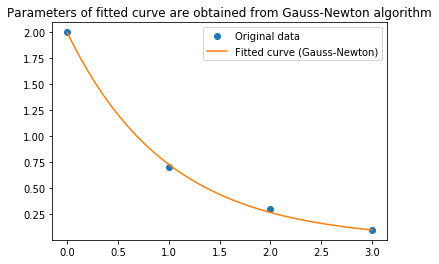

In [25]:
plt.figure()
x = np.linspace(0, 3, 100)
y_gauss_newton = new_theta_gauss_newton[0]*np.exp(new_theta_gauss_newton[1]*x)
plt.plot(x_data, y, 'o', label = "Original data")
plt.plot(x, y_gauss_newton, label = "Fitted curve (Gauss-Newton)")
plt.legend()
plt.title("Parameters of fitted curve are obtained from Gauss-Newton algorithm")
plt.show()

## Levenberg-Marquardt method

In [26]:
def levenberg_marquardt(f, Df, theta, lambda1, kmax = 100, tol = 1e-6):
    n = len(theta)
    x = theta
    lambd = lambda1
    objectives = [] 
    residuals = []
    successive_approximations = [np.hstack(x)]
    for k in range(kmax):
        fk = f(x)
        Dfk = Df(x)
        objectives.append(npl.norm(fk)**2)
        residuals.append(npl.norm(2*np.matmul(Dfk.T,fk)))
        if npl.norm(2*np.matmul(Dfk.T,fk)) < tol:
            break
        xt = x - npl.lstsq(np.vstack([Dfk,np.sqrt(lambd)*np.eye(n)]),np.vstack([fk,np.zeros((n,1))]))[0]
        if npl.norm(f(xt)) < npl.norm(fk):
            lambd = .8*lambd
            x = xt
            successive_approximations.append(np.hstack(x))
        else:
            lambd = 2.0*lambd
    return x, dict([("objectives", objectives),("residuals",residuals)]), np.vstack(successive_approximations)[:-1,:]

In [27]:
new_theta_leven, history, succ_approx_leven = levenberg_marquardt(residual_function, Jacobian, theta_initial, 
                                                                  lambda1 = 1, kmax = 100)

In [28]:
new_theta_leven

array([[ 1.99500326],
       [-1.00952439]])

In [29]:
history.keys()

dict_keys(['objectives', 'residuals'])

In [30]:
history['objectives']

[2.39,
 0.6219623271160555,
 0.1606450910843255,
 0.036432203979507166,
 0.008153893990402422,
 0.0028971549819774606,
 0.002101365973551863,
 0.0020055703460129504,
 0.0019967219675213607,
 0.00199611362974886,
 0.0019960830911280513,
 0.0019960819832830295,
 0.0019960819543721896,
 0.0019960819538295082]

In [31]:
history['residuals']

[8.982204629154248,
 1.6780539030648403,
 0.7007413098150254,
 0.3186597012602426,
 0.13135059947859248,
 0.04906746812465884,
 0.016518228350473854,
 0.004925500872861827,
 0.0012769935773831995,
 0.0002841797017627251,
 5.3904217074583715e-05,
 8.68833681788085e-06,
 1.1894843263615737e-06,
 1.3857426709027232e-07]

In [32]:
succ_approx_leven

array([[ 1.        ,  0.        ],
       [ 1.33076923, -0.42564103],
       [ 1.63590176, -0.71191712],
       [ 1.82949885, -0.86218786],
       [ 1.92786642, -0.94150451],
       [ 1.97075095, -0.98141219],
       [ 1.98719184, -0.99938099],
       [ 1.9927743 , -1.00637659],
       [ 1.99444624, -1.0086908 ],
       [ 1.99488288, -1.00933676],
       [ 1.99498102, -1.0094886 ],
       [ 1.9949998 , -1.00951867],
       [ 1.99500285, -1.00952368]])

Now we will fit a curve to the data using theta values obtained form Levenberg-Marquardt algorithm.

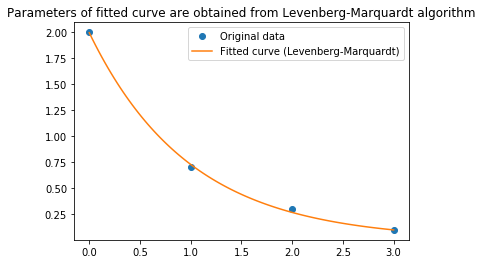

In [33]:
x = np.linspace(0,3,100)
y_leven = new_theta_leven[0]*np.exp(new_theta_leven[1]*x)
plt.plot(x_data,y, 'o', label = "Original data")
plt.plot(x, y_leven, label = "Fitted curve (Levenberg-Marquardt)")
plt.title("Parameters of fitted curve are obtained from Levenberg-Marquardt algorithm")
plt.legend()
plt.show()

Finally, we will compare the curves obtained by using parameters of Gauss-Newton and Levenberg-Marquardt
algorithms by plotting both the fits in a single figure along with the original data.

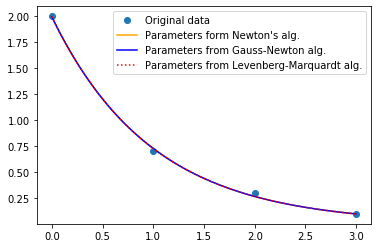

In [34]:
x = np.linspace(0,3,100)
# y_leven = new_theta_leven[0]*np.exp(new_theta_leven[1]*x)
plt.plot(x_data, y, 'o', label = "Original data")
plt.plot(x, y_newton, color = 'orange', label = "Parameters form Newton's alg.")
plt.plot(x, y_gauss_newton,'-',color = 'blue', label = "Parameters from Gauss-Newton alg.")
plt.plot(x, y_leven,':', color = "red", label = "Parameters from Levenberg-Marquardt alg.")
plt.legend()
plt.show()

As we can see, both the fits are indistinguishable. It can also be checked that parameters obtained from both the
methods match till 6 digits after decimal point. We have run Gauss-Newton for a maximum of 10 iterations
whereas Levenberg-Marquardt is run for 100 iterations.